# DCGAN to generate abstract art

**Author:** [Advitya Mittal] <br>
**Date created:** 2023/07/30<br>
**Description:** Implementing 4x and 16x super resolution EDSR on top of DCGAN trained using `fit()` by overriding `train_step` on images of Abstract art.


## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
from PIL import Image

import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Add, BatchNormalization, PReLU, LeakyReLU, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import Initializer

## Prepare Abstract Art data

We'll use face images from an Abstract art dataset, resized to 64x64 for efficient computation.

In [ ]:
if os.path.exists("art"):
    # Remove the "art" directory if it already exists
    import shutil
    shutil.rmtree("art")

os.makedirs("art")

url = "https://drive.google.com/uc?id=1zKQZ8lFYKZxpDUV1I4dq_eQR-f5L2yLB"
output = "art/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("art/data.zip", "r") as zipobj:
    zipobj.extractall("art")

Create a dataset from our folder, and rescale the images to the [0-1] range:

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    "art", label_mode=None, image_size=(64, 64), batch_size=32  # changing from 64,64
)
dataset = dataset.map(lambda x: x / 255.0)


Found 2872 files belonging to 1 classes.


Let's display a sample image:

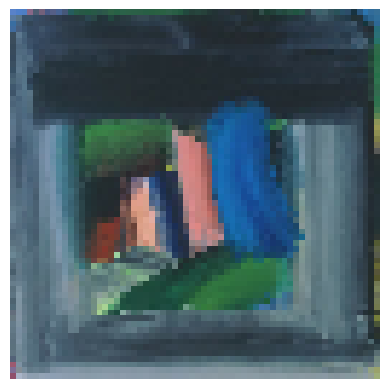

In [ ]:

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()
# discriminator = keras.Sequential(
#     [
#         keras.Input(shape=(128, 128, 3)),
#         layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Flatten(),
#         layers.Dropout(0.2),
#         layers.Dense(1, activation="sigmoid"),
#     ],
#     name="discriminator",
# )
# discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [ ]:
latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()
# latent_dim = 128

# generator = keras.Sequential(
#     [
#         keras.Input(shape=(latent_dim,)),
#         layers.Dense(8 * 8 * 128),
#         layers.Reshape((8, 8, 128)),
#         layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
#     ],
#     name="generator",
# )
# generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

## Override `train_step`

In [ ]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # # Combine them with real images
        # # Upscale the generated images to match the size of real images
        # generated_images = tf.image.resize(generated_images, (128, 128))

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## Create a callback that periodically saves generated images

In [ ]:

# class GANMonitor(keras.callbacks.Callback):
#     def __init__(self, num_img=3, latent_dim=128):
#         self.num_img = num_img
#         self.latent_dim = latent_dim
#         self.save_dir = "/content/sample_data/saved"

#     def on_epoch_end(self, epoch, logs=None):
#         random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
#         generated_images = self.model.generator(random_latent_vectors)
#         generated_images *= 255
#         generated_images.numpy()
#         for i in range(self.num_img):
#             img = keras.utils.array_to_img(generated_images[i])
#             #img.save("generated_img_%03d_%d.png" % (epoch, i))
#             img.save(os.path.join(self.save_dir, "generated_img_%03d_%d.png" % (epoch, i)))

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_dir = "/content/sample_data/saved"
        self.save_epochs = [1, 3, 7, 9, 10, 15, 25, 40, 60, 80, 100]  # Define the epochs to save images

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) in self.save_epochs:  # Check if the current epoch is in the save_epochs list
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            for i in range(self.num_img):
                img = keras.utils.array_to_img(generated_images[i])
                img.save(os.path.join(self.save_dir, "generated_img_%03d_%d.png" % (epoch + 1, i)))

## Train the end-to-end model

In [ ]:
epochs = 10  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0008),  # changed both from 0.0001
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0008),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/10
90/90 [==============================] - 47s 440ms/step - d_loss: 0.6161 - g_loss: 3.4331
Epoch 2/10
90/90 [==============================] - 44s 457ms/step - d_loss: 0.5863 - g_loss: 2.6660
Epoch 3/10
90/90 [==============================] - 44s 440ms/step - d_loss: -0.1744 - g_loss: 59.5434
Epoch 4/10
90/90 [==============================] - 43s 435ms/step - d_loss: -285.3616 - g_loss: 53948.1016
Epoch 5/10
90/90 [==============================] - 43s 442ms/step - d_loss: -921.5095 - g_loss: 150163.9531
Epoch 6/10
90/90 [==============================] - 43s 438ms/step - d_loss: -35183.7930 - g_loss: 4007577.0000
Epoch 7/10
90/90 [==============================] - 44s 446ms/step - d_loss: -122769.0234 - g_loss: 19043128.0000
Epoch 8/10
90/90 [==============================] - 43s 440ms/step - d_loss: -802985.8750 - g_loss: 73966248.0000
Epoch 9/10
90/90 [==============================] - 49s 471ms/step - d_loss: -100648.9453 - g_loss: 15961599.0000
Epoch 10/10
90/90 [=====

In [ ]:
# def srgan_generator(scale_factor=8, num_filters=64, num_res_blocks=16):
#     def res_block(inputs, num_filters):
#         x = Conv2D(num_filters, 3, padding='same')(inputs)
#         x = BatchNormalization()(x)
#         x = PReLU(alpha_initializer='zeros')(x)
#         x = Conv2D(num_filters, 3, padding='same')(x)
#         x = BatchNormalization()(x)
#         x = Add()([x, inputs])
#         return x

#     inputs = Input(shape=(None, None, 3))
#     x = Conv2D(num_filters, 9, padding='same')(inputs)
#     x = PReLU(alpha_initializer='zeros')(x)

#     for _ in range(num_res_blocks):
#         x = res_block(x, num_filters)

#     x = Conv2D(num_filters, 3, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Add()([x, inputs])

#     # Upsampling
#     for _ in range(int(np.log2(scale_factor))):
#         x = UpSampling2D(interpolation='bilinear')(x)
#         x = Conv2D(num_filters, 3, padding='same')(x)
#         x = PReLU(alpha_initializer='zeros')(x)

#     x = Conv2D(3, 9, padding='same', activation='sigmoid')(x)

#     model = Model(inputs, x)
#     return model


def edsr(scale_factor=4, num_filters=64, num_res_blocks=16):
    def res_block(inputs, num_filters):
        x = Conv2D(num_filters, 3, padding='same', activation='relu')(inputs)
        x = Conv2D(num_filters, 3, padding='same')(x)
        x = Add()([x, inputs])
        return x

    inputs = Input(shape=(None, None, 3))
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(inputs)

    for _ in range(num_res_blocks):
        x = res_block(x, num_filters)

    x = Conv2D(3 * scale_factor ** 2, 3, padding='same')(x)
    x = tf.nn.depth_to_space(x, scale_factor)

    model = Model(inputs, x)
    return model

# def edsr(scale_factor=16, num_filters=64, num_res_blocks=32):
#     def res_block(inputs, num_filters):
#         x = Conv2D(num_filters, 3, padding='same', activation='relu')(inputs)
#         x = Conv2D(num_filters, 3, padding='same')(x)
#         x = Add()([x, inputs])
#         return x

#     inputs = Input(shape=(None, None, 3))
#     x = Conv2D(num_filters, 3, padding='same', activation='relu')(inputs)

#     for _ in range(num_res_blocks):
#         x = res_block(x, num_filters)

#     x = Conv2D(3 * scale_factor ** 2, 3, padding='same')(x)
#     x = tf.nn.depth_to_space(x, scale_factor)

#     model = Model(inputs, x)
#     return model


# Data preparation
def load_images(path, target_size=(64, 64)):
    image_files = [file for file in os.listdir(path) if file.endswith(('.png', '.jpg', '.jpeg'))]
    images = []
    for image_file in image_files:
        image_path = os.path.join(path, image_file)
        try:
            image = Image.open(image_path)
            image = image.resize(target_size)  # Resize to target_size for low-res images
            image = np.array(image)
            images.append(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
    return np.array(images)

def normalize_images(images):
    return images.astype('float32') / 255.0

In [ ]:
# Load training data
train_lr_path = '/content/sample_data/train_lr'
train_hr_path = '/content/sample_data/train_hr'
train_lr_images = load_images(train_lr_path, target_size=(64, 64))
train_hr_images = load_images(train_hr_path, target_size=(256, 256)) # 256,256
print("Shape of train_lr_images:", train_lr_images.shape)
print("Shape of train_hr_images:", train_hr_images.shape)
# Normalize images
train_lr_images = normalize_images(train_lr_images)
train_hr_images = normalize_images(train_hr_images)

# Create and compile the model
model = edsr()
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
# Train the model
model.fit(train_lr_images, train_hr_images, epochs=20, batch_size=16)

# # Create and compile the model
# model = edsr(scale_factor=16)
# model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
# # Train the model
# model.fit(train_lr_images, train_hr_images, epochs=300, batch_size=16)

# Load the saved images
saved_images_path = '/content/sample_data/saved'
saved_images = load_images(saved_images_path)
saved_images = normalize_images(saved_images)

# Perform super-resolution
super_res_images = model.predict(saved_images)

# Save the super-resolved images
saved_super_res_path = '/content/sample_data/savedSuperRes'
os.makedirs(saved_super_res_path, exist_ok=True)
for i, super_res_image in enumerate(super_res_images):
    filename = f'super_res_{i}.png'
    save_path = os.path.join(saved_super_res_path, filename)
    tf.keras.preprocessing.image.save_img(save_path, super_res_image)

Some of the last generated images around epoch 30
(results keep improving after that):

![results](https://i.imgur.com/ove13lO.png)

<!-- https://i.imgur.com/h5MtQZ7l.png -->